In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import re
from pyMuellerMat.physical_models.charis_physical_models import *
from scipy import stats as scipy_stats
import vampires_calibration
from vampires_calibration.plotting import summarize_median_posterior, summarize_posteriors
import h5py
import corner
import shutil
import tqdm
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})
import json


In [2]:
def plot_corner_flat(chain, param_names, step_range=(0, None), median_or_max="median", num_bins=100):
    flat_chain = chain[step_range[0]:step_range[1], :, :].reshape(-1, chain.shape[-1])
    converted_chain = flat_chain.copy()

    for i, name in enumerate(param_names):
        if ".phi" in name:
            converted_chain[:, i] = converted_chain[:, i] / (2 * np.pi)

    if median_or_max == "median":
        truths = np.median(converted_chain, axis=0)
    elif median_or_max == "max":
        truths = []
        for i in range(converted_chain.shape[1]):
            hist, bin_edges = np.histogram(converted_chain[:, i], bins=num_bins)
            max_index = np.argmax(hist)
            max_val = (bin_edges[max_index] + bin_edges[max_index + 1]) / 2
            truths.append(max_val)
        truths = np.array(truths)
    else:
        raise ValueError("median_or_max must be 'median' or 'max'")
 
    fig = corner.corner(
        converted_chain,
        labels = [name.replace("delta_theta", "offset").replace("image_rotator", "imr") for name in param_names],
        truths=truths,
        plot_datapoints=False, label_kwargs={"fontsize":3}   # disables individual scatter points
    )

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.xaxis.labelpad = 40
        ax.yaxis.labelpad = 40

    plt.tick_params(axis='x', which='both', pad=5)
    plt.tick_params(axis='y', which='both', pad=5)
    return fig,ax

def load_chain_and_labels(h5_filename, txt_filename, include_logf=False):
    base, ext = os.path.splitext(h5_filename)
    h5_copy = base + "_copy" + ext
    shutil.copy(h5_filename, h5_copy)

    with h5py.File(h5_copy, 'r') as f:
        chain = f['mcmc']['chain'][:]

    with open(txt_filename, 'r') as f:
        p0_dict = json.load(f)

    param_names = [f"{comp}.{param}" for comp, params in p0_dict.items() for param in params]
    if include_logf:
        param_names.append("log_f")

    return chain, param_names
p0_dict = {
    "image_rotator" : 
        {"d": 1, "delta_theta": 2},
    "hwp" :  
        {"w_SiO2": 3, "w_MgF2": 4, "delta_theta": 5},
    "lprot" : 
        {"pa": 6},
}
with open('mcmcp0.json','w') as f:
    json.dump(p0_dict,f)

(40000, 24, 5)


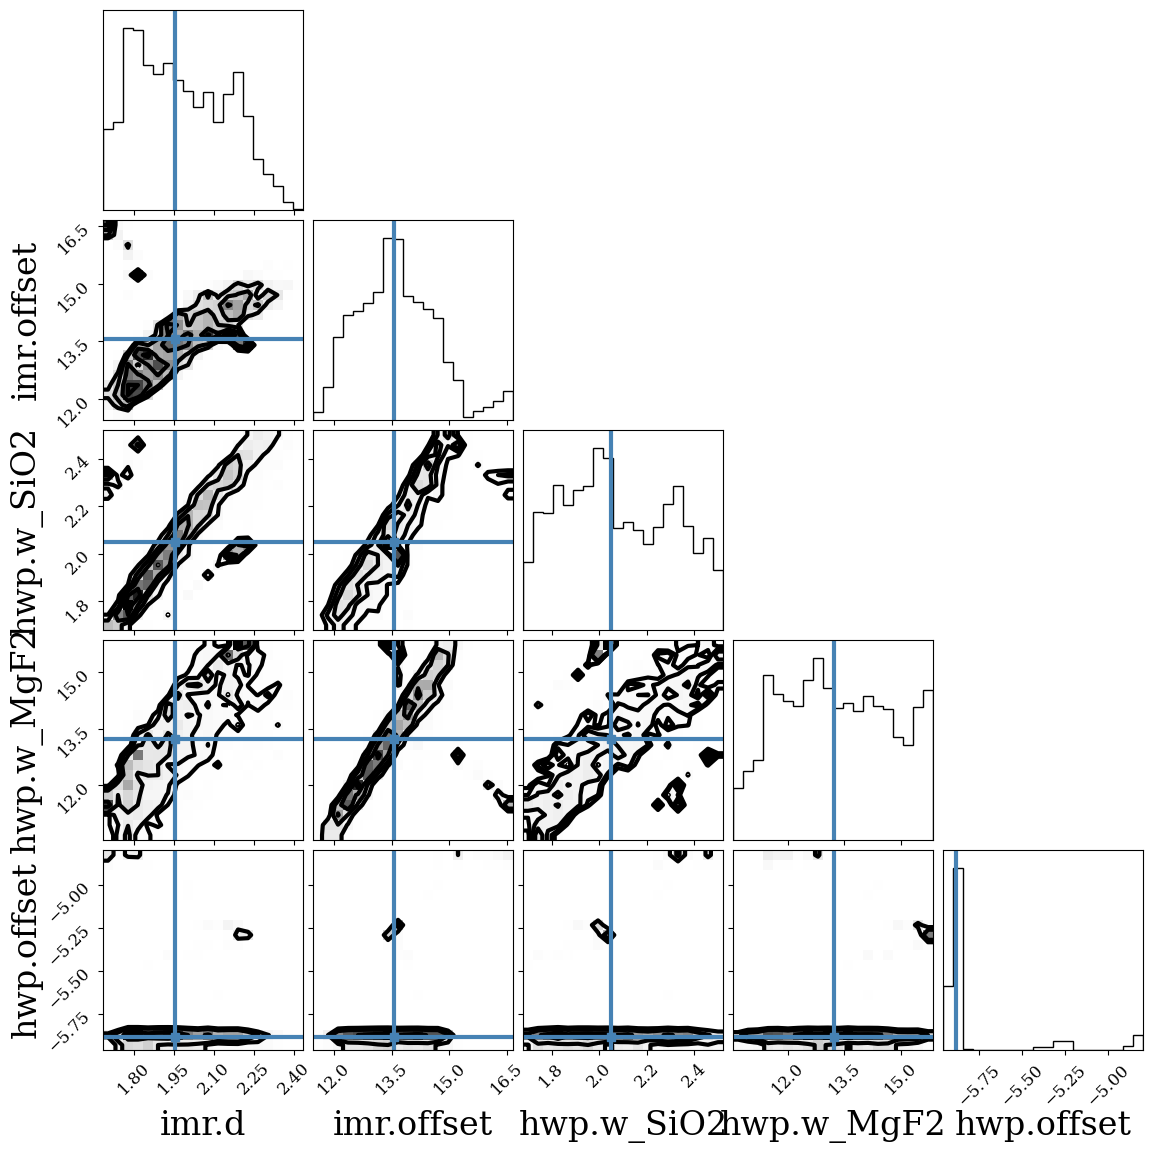

In [7]:
output_h5 = Path('../mcmc_output_M3.h5')
json_filepath = 'mcmcp0.json'
chain, names = load_chain_and_labels(output_h5, json_filepath, include_logf = True)
corner_plot_step_range = (1000,2000)
fig,ax = plot_corner_flat(chain, names, step_range=corner_plot_step_range)
print(chain.shape)
for ax in fig.get_axes():
    if ax.xaxis.label:  # check label exists
        ax.xaxis.label.set_fontsize(24)  # your desired size
    if ax.yaxis.label:
        ax.yaxis.label.set_fontsize(24)
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/cornerstd1.png',dpi=600,bbox_inches='tight')

In [9]:
summarize_median_posterior(output_h5,p0_dict,step_range=(1000,2000))
theta = [259.1,0.18519,1.65831,1.29482,-0.88466,-0.42809]

Posterior Medians and 1 sigma Credible Intervals:
image_rotator,d: 1.95486 (+0.22592/-0.16669)
image_rotator,delta_theta: 13.56188 (+1.06675/-1.00810)
hwp,w_SiO2: 2.04883 (+0.29290/-0.22144)
hwp,w_MgF2: 13.21302 (+1.76056/-1.52307)
hwp,delta_theta: -5.88376 (+0.03514/-0.02129)


IndexError: index 5 is out of bounds for axis 1 with size 5

In [8]:
import numpy as np
import emcee

def get_map_from_emcee_h5(h5_path, discard=0, thin=1, var_names=None):
    """
    Return the MAP (maximum a posteriori) parameter vector from an emcee HDF5 backend.

    Parameters
    ----------
    h5_path : str or Path
        Path to the emcee .h5 file (created with emcee.backends.HDFBackend).
    discard : int, optional
        Number of initial steps to discard as burn-in (default 0).
    thin : int, optional
        Thinning factor (default 1).
    var_names : list[str], optional
        Optional list of parameter names; if provided and matches ndim,
        a dict of {name: value} is returned alongside the array.

    Returns
    -------
    map_params : np.ndarray
        The parameter vector at the maximum posterior sample (shape: [ndim]).
    info : dict
        Metadata with keys:
          - 'logp': MAP log-posterior value
          - 'step': step index (after discard/thin)
          - 'walker': walker index
          - 'flat_index': index in flattened chain
          - 'mapping' (optional): dict of {var_name: value} if var_names given
    """
    backend = emcee.backends.HDFBackend(h5_path)

    # Get chains & logp with original (step, walker, dim) shapes
    chain = backend.get_chain(discard=discard, thin=thin, flat=False)      # (nsteps, nwalkers, ndim)
    logp  = backend.get_log_prob(discard=discard, thin=thin, flat=False)   # (nsteps, nwalkers)

    # Handle any NaNs by treating them as -inf
    logp_safe = np.where(np.isfinite(logp), logp, -np.inf)

    # Locate MAP sample
    imax = np.nanargmax(logp_safe)
    step_idx, walker_idx = np.unravel_index(imax, logp_safe.shape)

    map_params = chain[step_idx, walker_idx, :].copy()
    map_logp   = float(logp_safe[step_idx, walker_idx])

    # Also compute flat index if you care
    nsteps, nwalkers = logp_safe.shape
    flat_index = step_idx * nwalkers + walker_idx

    info = {
        "logp": map_logp,
        "step": int(step_idx),
        "walker": int(walker_idx),
        "flat_index": int(flat_index),
    }

    if var_names is not None and len(var_names) == map_params.shape[0]:
        info["mapping"] = dict(zip(var_names, map_params))

    return map_params, info


In [9]:
get_map_from_emcee_h5(output_h5,1000,var_names=['d','imr_offset','wsio2','mgf2','hwp_offset','lp_offset','logf'])

(array([ 2.59167366e+02,  1.64272128e-01,  1.67749446e+00,  1.30912054e+00,
        -8.80778355e-01, -4.64374498e-01, -2.67704783e+00]),
 {'logp': 1484.58642578125,
  'step': 271,
  'walker': 19,
  'flat_index': 6523,
  'mapping': {'d': 259.167366126782,
   'imr_offset': 0.16427212764906346,
   'wsio2': 1.6774944640456533,
   'mgf2': 1.3091205356138493,
   'hwp_offset': -0.8807783547882065,
   'lp_offset': -0.46437449822734095,
   'logf': -2.677047828103286}})

Interleaved Values


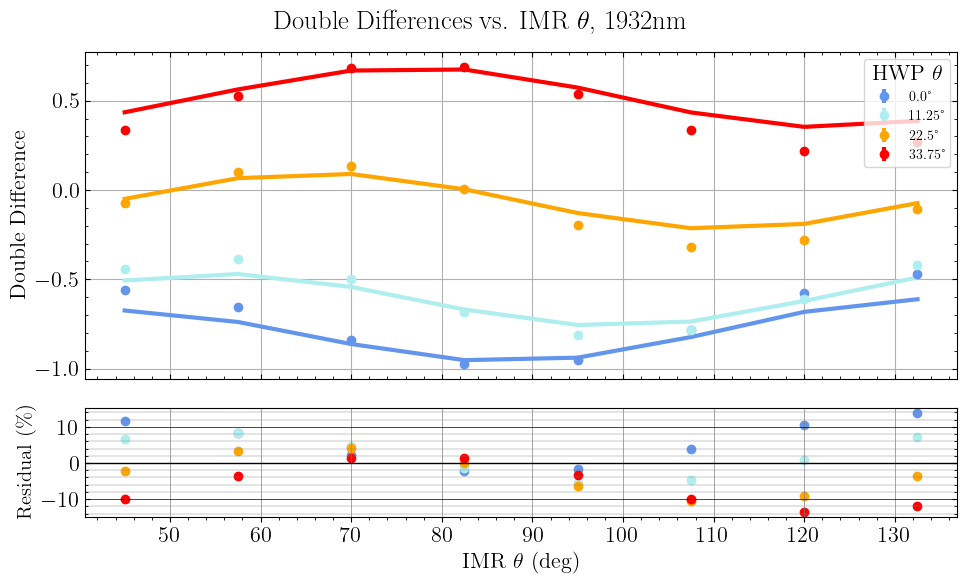

In [6]:
# Make a plot of the mcmc results
wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])
offset_imr =0.18519 # derotator offset
offset_hwp = -0.87823 # HWP offset
offset_cal =  -0.44630 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "rotation matrix": {
                "type": "rotator_function",
                "properties" : {'pa':offset_cal},
            "tag": "internal",
                 
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"epsilon":0.9632},
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

# Load in data
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff.csv')
interleaved_values, interleaved_stds, configuration_list = inst.read_csv(filepath)
print("Interleaved Values")


# Get our model retardances 
wsio2_ = 1.66725
wmgf2_ = 1.30159
d_ = 259.19373
p = [HWP_retardance(wavelength_bins,wsio2_,wmgf2_)[15], IMR_retardance(wavelength_bins,d_)[15]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

diffs_sums =model(p, system_parameters, system_mm, configuration_list,process_model=process_model)

# Process these into interleaved single norm differences and sums



# Plot the modeled and observed values


fig_imr, ax_imr,small_ax = inst.plot_data_and_model_x_imr(interleaved_values, interleaved_stds, diffs_sums,configuration_list, hwp_theta_filter=[0,11.25,22.5,33.75],wavelength= wavelength_bins[15], title=r'Double Differences vs. IMR $\theta$, 1932nm')
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax_imr.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
# Show minor ticks
ax_imr.minorticks_on()
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',
      # both major and minor
)
small_ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)




# Show minor ticks
small_ax.minorticks_on()
#fig_imr.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/dd_plots/MCMC_vs_imr_1575.png', bbox_inches='tight', dpi=600)


# Print residuals (will be useful later to see if your fit improved at a quick glance)

